# Contextual Quantum Neural Network for Stock Pricing

TODO: Create target output for prediction circuit and implement SWAP test

## Preprocessing of data 
Convert log-returns into probability distribution of qubit features

In [1]:
VERBOSE = True # Testing

import pandas as pd
# load data from log-returns

df_returns = pd.read_csv('squashed_log_returns.csv')

print(df_returns.head())

       AAPL      AMZN      GOOG      MSFT
0 -0.000076  0.005513  0.007070  0.002016
1  0.002013  0.001940  0.001570  0.003806
2  0.004917  0.006963  0.006282  0.005351
3 -0.001616  0.006220  0.001852  0.000443
4 -0.000050  0.002026 -0.000267 -0.000295


In [2]:

#split into windows
WINDOW_SIZE = 4 #time windows of 4

df = pd.DataFrame(columns=['context','raw_features','raw_label'])
    
for context, ticker in enumerate(df_returns.columns):
        
    stock_series = df_returns[ticker]
        
    # Slide a window across this one stock's time series
    # We stop (window_size - 1) from the end
    for i in range(len(stock_series) - WINDOW_SIZE + 1):
            
        # The full window (e.g., 4 log-returns)
        window = stock_series.iloc[i : i + WINDOW_SIZE]
            
        # Features are the first N-1 (e.g., 3)
        features = window[:-1].values
            
        # Label is the last one (e.g., the 4th)
        label = window.iloc[-1]

        df.loc[len(df)] = [context, features, label]

print(df.head())

   context                                       raw_features  raw_label
0        0  [-7.570098556833607e-05, 0.002012513590532, 0....  -0.001616
1        0  [0.002012513590532, 0.0049166646207804, -0.001...  -0.000050
2        0  [0.0049166646207804, -0.0016160763885611, -4.9...  -0.000100
3        0  [-0.0016160763885611, -4.977979782626501e-05, ...   0.002460
4        0  [-4.977979782626501e-05, -9.973891197457896e-0...   0.004462


In [3]:
# Convert features and labels to N_BINS using context-specific min/max ranges
import numpy as np

# Number of bins (change this to >2 to get more than binary bins)
N_BINS = 2

# Get per-stock min/max from the original log-returns table
return_mins = df_returns.min()
return_maxs = df_returns.max()

# Precompute bin edges for each context (index corresponds to context integer)
edges_per_context = [np.linspace(return_mins.iloc[i], return_maxs.iloc[i], N_BINS + 1)
                     for i in range(len(return_mins))]

# Helper: bin an ndarray of values for a given context
def bin_array(arr, context):
    ctx = int(context)
    edges = edges_per_context[ctx]
    # interior edges (length = N_BINS-1). np.digitize with these yields indices 0..N_BINS-1
    interior = edges[1:-1]
    arr = np.asarray(arr, dtype=float)
    if interior.size == 0:
        # degenerate case (N_BINS <= 2), use midpoint logic
        midpoint = edges[1]
        return np.array([int(x > midpoint) for x in arr], dtype=int)
    return np.digitize(arr, interior).astype(int)

# Helper: bin a single scalar value
def bin_scalar(val, context):
    ctx = int(context)
    edges = edges_per_context[ctx]
    interior = edges[1:-1]
    v = float(val)
    if interior.size == 0:
        midpoint = edges[1]
        return int(v > midpoint)
    return int(np.digitize([v], interior)[0])

# Apply binning to each row: features (elementwise) and label (scalar)
df['features'] = df.apply(lambda row: bin_array(row['raw_features'], row['context']), axis=1)
df['label'] = df.apply(lambda row: bin_scalar(row['raw_label'], row['context']), axis=1)

if VERBOSE: #Testing
    # Verification prints
    print('\nSample rows after binning:')
    for _, row in df.head(5).iterrows():
        ctx = int(row['context'])
        print(f"\nContext {ctx} (edges={edges_per_context[ctx]}):")
        print(f"  raw_features: {row['raw_features']}")
        print(f"  binned features: {row['features']}")
        print(f"  raw_label: {row['raw_label']}")
        print(f"  binned label: {row['label']}")


Sample rows after binning:

Context 0 (edges=[-0.05973468 -0.00531524  0.0491042 ]):
  raw_features: [-7.57009856e-05  2.01251359e-03  4.91666462e-03]
  binned features: [1 1 1]
  raw_label: -0.0016160763885611
  binned label: 1

Context 0 (edges=[-0.05973468 -0.00531524  0.0491042 ]):
  raw_features: [ 0.00201251  0.00491666 -0.00161608]
  binned features: [1 1 1]
  raw_label: -4.977979782626501e-05
  binned label: 1

Context 0 (edges=[-0.05973468 -0.00531524  0.0491042 ]):
  raw_features: [ 4.91666462e-03 -1.61607639e-03 -4.97797978e-05]
  binned features: [1 1 1]
  raw_label: -9.973891197457896e-05
  binned label: 1

Context 0 (edges=[-0.05973468 -0.00531524  0.0491042 ]):
  raw_features: [-1.61607639e-03 -4.97797978e-05 -9.97389120e-05]
  binned features: [1 1 1]
  raw_label: 0.0024599308278872
  binned label: 1

Context 0 (edges=[-0.05973468 -0.00531524  0.0491042 ]):
  raw_features: [-4.97797978e-05 -9.97389120e-05  2.45993083e-03]
  binned features: [1 1 1]
  raw_label: 0.00446

In [4]:
# split into train and test sets

TRAIN_RATIO = 0.8  # take the first 80% of df as requested

# Compute split index using the row order (first 80%)
n_rows = len(df)
split_index = int(n_rows * TRAIN_RATIO)

# First 80% (preserve original order); create df_test for remainder
df_train = df.iloc[:split_index].reset_index(drop=True)
df_test = df.iloc[split_index:].reset_index(drop=True)

print(df_train.shape)
print(df_test.shape)

(4816, 5)
(1204, 5)



Probability distribution of feature patterns:
--------------------------------------------------
Pattern    | Probability | Count
--------------------------------------------------
[0,0,0]    |      0.013 |    64
[0,0,1]    |      0.044 |   211
[0,1,0]    |      0.039 |   187
[0,1,1]    |      0.120 |   578
[1,0,0]    |      0.044 |   211
[1,0,1]    |      0.115 |   555
[1,1,0]    |      0.120 |   579
[1,1,1]    |      0.505 |  2431

Total probability: 1.000000
Total samples: 4816


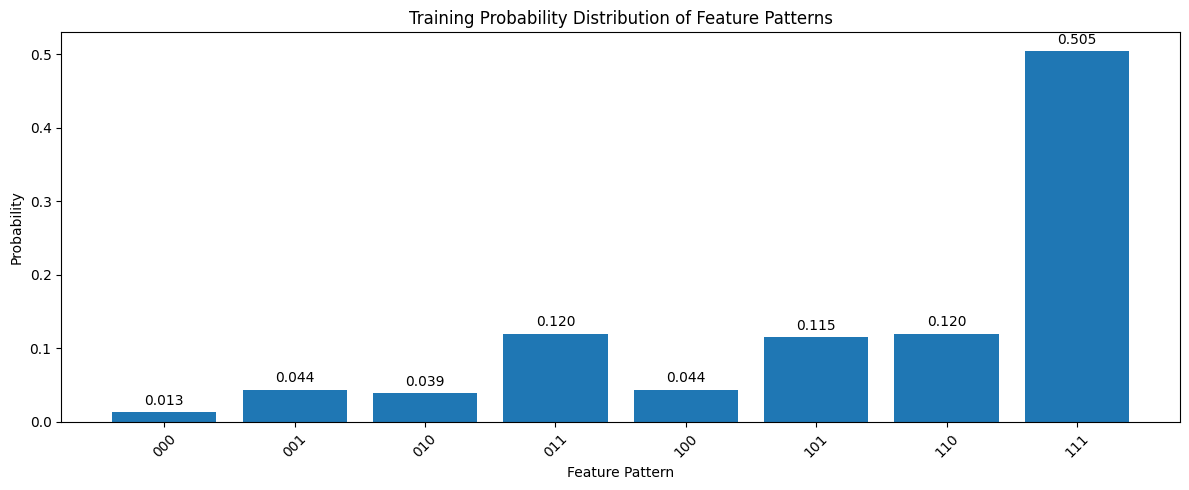

In [ ]:
# Analyze global probability distribution of feature patterns
from itertools import product
import matplotlib.pyplot as plt

# Get dimensions
n_features = df_train['features'].iloc[0].shape[0]  # Should be 3
n_patterns = 2**n_features  # 8 possible patterns for 3 binary features

# Generate all possible patterns in natural binary order
patterns = np.array(list(product([0, 1], repeat=n_features)))
pattern_strs = [''.join(map(str, p)) for p in patterns]

# Stack all feature vectors into a 2D array
all_features = np.stack(df_train['features'].values)

# Count occurrences of each pattern
counts = np.zeros(n_patterns)
for i, pattern in enumerate(patterns):
    matches = np.all(all_features == pattern, axis=1)
    counts[i] = np.sum(matches)

# Convert to probabilities
probs = counts / counts.sum()

if VERBOSE:
    # Print probabilities in natural binary order
    print("\nProbability distribution of feature patterns:")
    print("-" * 50)
    print("Pattern    | Probability | Count")
    print("-" * 50)
    for i in range(n_patterns):
        pattern_str = f"[{','.join(map(str, patterns[i]))}]"
        print(f"{pattern_str:10s} | {probs[i]:10.3f} | {int(counts[i]):5d}")

# Verify distribution sums to 1
print(f"\nTotal probability: {probs.sum():.6f}")
print(f"Total samples: {int(counts.sum())}")

# Plot bar chart (keeping natural binary order)
plt.figure(figsize=(12, 5))
plt.bar(pattern_strs, probs)
plt.xticks(rotation=45)
plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Training Probability Distribution of Feature Patterns')

# Add probability values on top of bars
for i, v in enumerate(probs):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

#TODO: Generate target output probability distribution

## Create state-preparation circuit to load probability distribution into an approximate quantum state
For now, we are using parameter-shift

In [39]:
# State preparation circuit (hardware-efficient ansatz)
import pennylane as qml

L_SP = 2 # number of layers for state preparation ansatz
N_WIRES_SP = WINDOW_SIZE - 1  # 3 qubits for 3 features

dev_sp = qml.device("default.qubit", wires=N_WIRES_SP)

def hardware_efficient_ansatz(params, n_wires=N_WIRES_SP):
    #Hadamard layer
    for i in range(n_wires):
        qml.Hadamard(wires=i)

    #Optimization layers
    for l in range(L_SP):
        for i in range(n_wires):
            qml.RY(params[l][i][0], wires=i)
            qml.RZ(params[l][i][1], wires=i)

        for j in range(n_wires):
            qml.CNOT(wires=[j, (j + 1) % n_wires])

@qml.qnode(dev_sp, interface='torch', diff_method='parameter-shift')
def sp_circuit(params):

    hardware_efficient_ansatz(params)

    return qml.probs(wires=range(N_WIRES_SP))

Starting SPSA training for state preparation...
Epoch 10/100 - MSE Loss: 0.004319
Epoch 20/100 - MSE Loss: 0.001324
Epoch 30/100 - MSE Loss: 0.000925
Epoch 40/100 - MSE Loss: 0.000781
Epoch 50/100 - MSE Loss: 0.000602
Epoch 60/100 - MSE Loss: 0.000356
Epoch 70/100 - MSE Loss: 0.000322
Epoch 80/100 - MSE Loss: 0.000302
Epoch 90/100 - MSE Loss: 0.000291
Epoch 100/100 - MSE Loss: 0.000290

Target probs:
 [0.013289 0.043812 0.038829 0.120017 0.043812 0.115241 0.120224 0.504776]
Final prepared probs:
 [0.024013 0.056618 0.05477  0.079803 0.047946 0.119012 0.124191 0.493648]
[0.02217445944905211, 0.014589093976149686, 0.007938679129412027, 0.003900594111952206, 0.0027317641096840347, 0.0033701759048583757, 0.0043856989122233285, 0.004952995481590087, 0.004889596056014332, 0.004319136338029259, 0.0035009135531328967, 0.0027707900617324633, 0.0024069435011104616, 0.0023289024761900703, 0.0022146379451946905, 0.0019748726912623736, 0.0016960361477038745, 0.0014732771416813223, 0.001351525805010

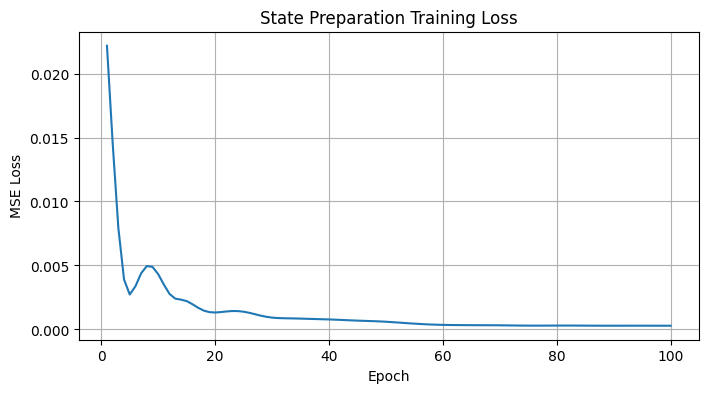

In [42]:
# Train the hardware-efficient ansatz to prepare the target probability distribution using PennyLane's SPSA optimizer
import torch
import torch.nn as nn

N_EPOCHS_SP = 100
LEARNING_RATE_SP = 0.1
INIT_PARAM_SCALE = 0.01

target_probs = torch.tensor(probs, dtype=torch.float64)
#print('target_probs', target_probs)

# Initialize parameters as a NumPy array
params = nn.Parameter(torch.randn(L_SP, N_WIRES_SP, 2) * INIT_PARAM_SCALE)

# Create SPSA optimizer
opt_sp = torch.optim.Adam([params], lr=LEARNING_RATE_SP)

loss_fn_sp = nn.MSELoss()

# Training loop using SPSA optimizer
print("Starting SPSA training for state preparation...")
losses_sp = []

for epoch in range(N_EPOCHS_SP):
    # Single SPSA update step

    y_pred = sp_circuit(params)

    #print('y_pred:', y_pred)

    loss = loss_fn_sp(y_pred, target_probs)

    loss.backward()

    opt_sp.step()

    opt_sp.zero_grad()

    losses_sp.append(loss.item())
    
    # Print progress
    if (epoch + 1) % max(1, (N_EPOCHS_SP // 10)) == 0 or epoch == N_EPOCHS_SP - 1:
        print(f"Epoch {epoch+1}/{N_EPOCHS_SP} - MSE Loss: {loss:.6f}")

# Get final distribution
final_out = sp_circuit(params)

# Detach from autograd graph for final printing/plotting
final_out_np = final_out.detach().numpy()
target_out_np = target_probs.detach().numpy()

print("\nTarget probs:\n", np.round(target_out_np, 6))
print("Final prepared probs:\n", np.round(final_out_np, 6))

print(losses_sp, type(losses_sp), losses_sp)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(losses_sp) + 1), losses_sp)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('State Preparation Training Loss')
plt.grid(True)
plt.show()

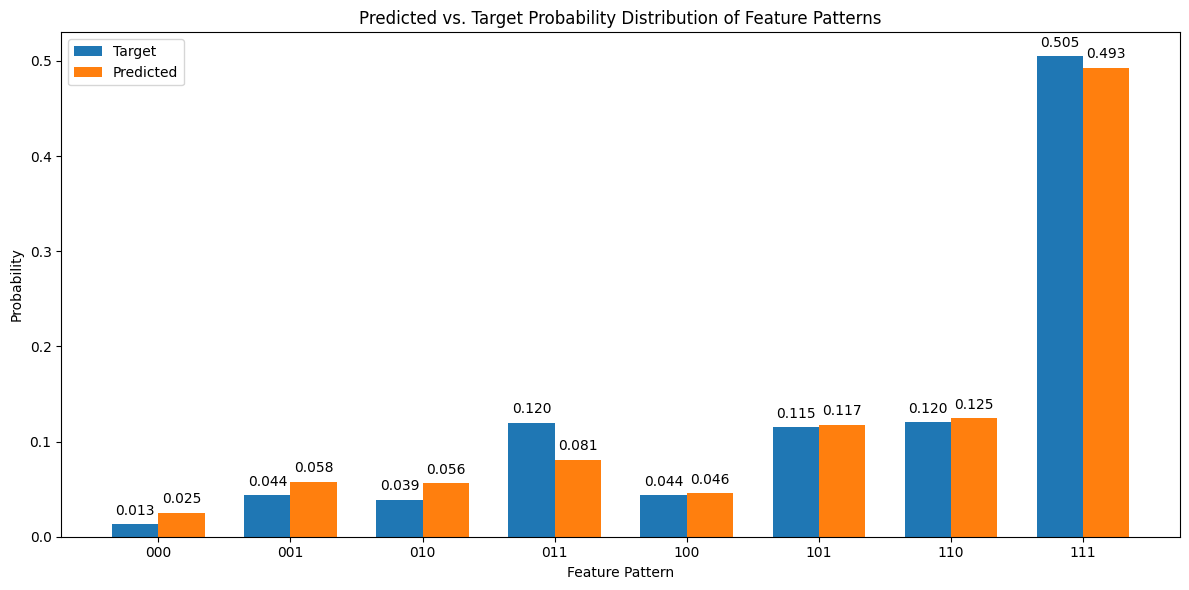

In [41]:
#Plot target probabilities and predicted probabilites
x = np.arange(len(pattern_strs))
width = 0.35  # Width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, target_out_np, width, label='Target')
plt.bar(x + width/2, final_out_np, width, label='Predicted')

plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Predicted vs. Target Probability Distribution of Feature Patterns')
plt.xticks(x, pattern_strs)
plt.legend()

# Add probability values on top of bars
for i, (v1, v2) in enumerate(zip(target_out_np, final_out_np)):
    plt.text(i - width/2, v1 + 0.01, f'{v1:.3f}', ha='center')
    plt.text(i + width/2, v2 + 0.01, f'{v2:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Create Prediction Circuit (Quantum Single-Task Learning)
For now, we are using parameter-shift

In [38]:
#Build the circuit

# 0-1: context qubits
# 2-4: input qubits
# 5: output qubit
N_CONTEXT_WIRES = int(np.log2(df_returns.shape[1]))  # Number of qubits needed to represent stocks
N_INPUT_WIRES = df_train['features'].loc[0].shape[0]  # Should be 3
N_OUTPUT_WIRES = int(np.log2(N_BINS))
N_TOTAL_WIRES = N_CONTEXT_WIRES + N_INPUT_WIRES + N_OUTPUT_WIRES

N_LAYERS = 2

LEARNING_RATE = 0.01
N_EPOCHS = 10

input_wires = list(range(N_INPUT_WIRES))
output_wires = list(range(N_INPUT_WIRES, N_INPUT_WIRES + N_OUTPUT_WIRES))
context_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES, N_TOTAL_WIRES))
comp_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES))

dev = qml.device("default.qubit", wires=N_TOTAL_WIRES)

# layer for both either the shared or specify ansatz (input is just trainable parameters)
def U_ss(params):
    """A single (L=1) ansatz layer (Rotations + CNOTs)."""
    # 1. Trainable Rotations
    for i, wire in enumerate(comp_wires):
        qml.RY(params[i], wires=wire)
    
    # 2. Entangling "Ring"
    for i in range(len(comp_wires)):
        qml.CNOT(wires=[comp_wires[i], comp_wires[(i + 1) % len(comp_wires)]])

@qml.qnode(dev, interface='torch', diff_method='parameter-shift')
def qmtl_circuit(params, context): # context is a classical input for now (what a drag...)
    
    # Approximate state preparation on input wires
    hardware_efficient_ansatz(params, N_INPUT_WIRES)

    #Implement shared variational layers
    for l in range(N_LAYERS):
        U_ss(params['shared'][l])

    #TODO: Implement actual control gates for specify layers (allows for superposition of contexts later)
    for l in range(N_LAYERS):
        U_ss(params['spec'][context][l])

    # Measure output qubit (wire 5)
    return qml.probs(wires=N_CONTEXT_WIRES + N_INPUT_WIRES)


In [ ]:
#Train prediction circuit
#TODO: SWAP Test & refactor to implement QSTL

import torch
import torch.nn as nn

LEARNING_RATE = 0.01
N_EPOCHS = 10

def init_params():
    """
    Initialize the trainable parameters using torch.nn.Parameter
    """
    n_params_per_layer = len(comp_wires) # 3 input + 1 output = 4
    
    # --- Shared Parameters ---
    # We need L=2 layers of 4 params each
    shared_params = torch.randn(N_LAYERS, n_params_per_layer, requires_grad=True)
    
    # --- Specify Parameters ---
    # We need K=4 sets of (L=2 layers * 4 params each)
    n_stocks = 2**N_CONTEXT_WIRES
    spec_params = torch.randn(n_stocks, N_LAYERS, n_params_per_layer, requires_grad=True)
    
    # We use torch.nn.ParameterDict to keep them organized
    return nn.ParameterDict({
        "shared": nn.Parameter(shared_params),
        "spec": nn.Parameter(spec_params)
    })

#Train the circuit
params = init_params()

optimizer = torch.optim.Adam(params.values(), lr=LEARNING_RATE)

#KL-Divergence used
loss_fn = nn.KLDivLoss()

print("\n--- Starting Training ---")
    
    # --- Run Epochs ---
for epoch in range(N_EPOCHS):
    total_loss = 0
    
    # We loop through the training set one sample at a time
    # (This is Stochastic Gradient Descent, Batch Size = 1)
    for index, row in df_train.iloc[:50].iterrows(): #Only first 50 for testing purposes
        
        # Create the one-hot true label vector [P(0), P(1)]
        y_true_onehot = torch.tensor([0.0, 0.0])
        y_true_onehot[row['label']] = 1.0
        
        # 2. Run circuit, y_pred = [P(0), P(1)]
        y_pred = qmtl_circuit(params, row['features'], row['context'])
        
        # Calculate Loss
        # **CRITICAL**: KLDivLoss expects log-probabilities
        loss = loss_fn(torch.log(y_pred), y_true_onehot)
        
        # Calculate Gradients
        # PyTorch and PennyLane work together to run the parameter-shift rule for ALL parameters.
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Clear gradients
        optimizer.zero_grad()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(df_train)
    print(f"Epoch {epoch+1}/{N_EPOCHS} - Avg. Loss: {avg_loss:.4f}")

    print("--- Training Complete ---")
    print("Final Parameters (Shared):")
    print(params['shared'])
    print("Final Parameters (Specify):")
    print(params['spec'])


--- Starting Training ---


c:\Users\antho\anaconda3\envs\quantum\Lib\site-packages\torch\nn\functional.py:3355: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1/10 - Avg. Loss: 0.0026
--- Training Complete ---
Final Parameters (Shared):
Parameter containing:
tensor([[ 0.0663,  1.0921, -1.1503,  0.7243],
        [-0.7098,  0.2456, -0.2202,  1.4512]], requires_grad=True)
Final Parameters (Specify):
Parameter containing:
tensor([[[-1.7667, -0.4806, -1.2539,  0.7395],
         [ 1.5891,  0.6025, -1.5270,  0.8520]],

        [[ 0.6428, -0.2284,  1.8288,  1.2051],
         [ 1.1416, -1.2565, -0.3173, -3.1662]],

        [[ 0.3604, -1.3728,  0.2914, -0.3286],
         [-0.8405, -0.2691, -1.3748,  0.3163]],

        [[ 1.5240, -1.0766,  1.3405,  1.3979],
         [-1.7964,  0.8130,  1.4642, -0.9760]]], requires_grad=True)
Epoch 2/10 - Avg. Loss: 0.0025
--- Training Complete ---
Final Parameters (Shared):
Parameter containing:
tensor([[ 0.0611,  1.1070, -1.1559,  0.7240],
        [-0.7098,  0.2484, -0.2511,  1.4537]], requires_grad=True)
Final Parameters (Specify):
Parameter containing:
tensor([[[-1.7423, -0.4791, -1.2786,  0.7147],
         [ 